In [1]:
using NPZ
using Plots
using PaddedViews

# Wczytanie danych

In [2]:
train_dict = npzread("KMNIST/kmnist-train-imgs.npz")
train_labels = npzread("KMNIST/kmnist-train-labels.npz")
test_dict = npzread("KMNIST/kmnist-test-imgs.npz")
test_labels = npzread("KMNIST/kmnist-test-labels.npz");

In [3]:
labels = ["o", "ki", "su", "tsu", "na", "ha", "ma", "ya", "re", "wo"];

In [4]:
train_y = convert(Vector{Int64}, train_labels["arr_0"])
test_y = convert(Vector{Int64}, test_labels["arr_0"])

train_x = convert(Array{Float32}, train_dict["arr_0"])/255
train_x = permutedims(train_x, (2,3,1))
train_x = reshape(train_x, (28,28,1,60000))
print(size(train_x))

test_x = convert(Array{Float32}, test_dict["arr_0"])/255
test_x = permutedims(test_x, (2,3,1))
test_x = reshape(test_x, (28,28,1,10000));

(28, 28, 1, 60000)

8 ya


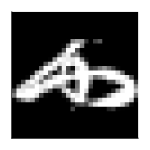

In [5]:
img = train_x[:,:,:,2];
img_label = train_y[2];

img = reshape(img, (28,28,1))
img_label = [img_label]

println(img_label[1]+1, " ", labels[img_label[1]+1])

plot(Gray.(img[:,:,1]), axis=nothing, size=(150,150))

# Graf obliczeniowy

In [6]:
abstract type Node end
abstract type Operator <: Node end

struct Constant{Float64} <: Node
    output::Float64
end

mutable struct Variable <: Node
    output::Array{Float64}
    gradient::Array{Float64}
    name::String
    v::Array{Float64}
    s::Array{Float64}
    temp::Array{Float64}
    Variable(output; name = "?") = new(output, [], name, zeros(size(output)), zeros(size(output)), zeros(size(output)))
end

mutable struct NodeOperator{F} <: Operator
    inputs
    output
    gradient
    name::String
    NodeOperator(fun, inputs...; name = "?") = new{typeof(fun)}(inputs, [], [], name)
end

In [7]:
import Base: show, summary
show(io::IO, x::NodeOperator{F}) where {F} = print(io, "op ", "(", F, ")");
show(io::IO, x::Constant) = print(io, "const ", x.output)
show(io::IO, x::Variable) = begin
    print(io, "var ", x.name);
    print(io, "\n ┣━ ^ "); summary(io, x.output)
    print(io, "\n ┗━ ∇ ");  summary(io, x.gradient)
end

show (generic function with 392 methods)

In [8]:
function visit(node::Node, visited::Set, order::Vector)
    if node ∉ visited
        push!(visited, node)
        push!(order, node)
    end
end

function visit(node::Operator, visited::Set, order::Vector)
    if node ∉ visited
        for input in node.inputs
            visit(input, visited, order)
        end
        push!(visited, node)
        push!(order, node)
    end
end


function create_graph(root::Node)
    visited = Set()
    order = Vector()
    visit(root, visited, order)
end

create_graph (generic function with 1 method)

In [9]:
zero_gradient!(node::Variable) = node.gradient = []
zero_gradient!(node::Constant) = nothing
zero_gradient!(node::Operator) = node.gradient = []

compute!(node::Variable) = nothing
compute!(node::Constant) = nothing
compute!(node::Operator) = node.output = forward(node, [input.output for input in node.inputs]...)

function forward!(order::Vector)
    for node in order
        compute!(node)
        zero_gradient!(node)
    end
    
    return last(order).output
end    

forward! (generic function with 1 method)

In [10]:
update!(node::Constant, gradient) = nothing
update!(node::Node, gradient) = if isempty(node.gradient)
    node.gradient = gradient else node.gradient += gradient
    #println("YES \n", node.name, size(gradient)); node.gradient = gradient else println("NO \n", node.name, size(gradient), size(node.gradient)); node.gradient += gradient
end

function backward!(order::Vector; seed = 1.0)
    result = last(order)
    result.gradient = seed
    
    for node in reverse(order)
        backward!(node)
    end
end

backward!(node::Variable) = nothing
backward!(node::Constant) = nothing
function backward!(node::Operator)
    gradients = backward(node, [input.output for input in node.inputs]..., node.gradient)
    #println("\nCurrent ", node)
    for (input, gradient) in zip(node.inputs, gradients)
       # println("inputs ",input.name, " ", size(gradient))
        update!(input, gradient)
    end
end

backward! (generic function with 4 methods)

# Sieć i warstwy

In [11]:
mutable struct ConvParams
    kernels::Variable
    bias::Variable
end

mutable struct DenseParams
    weights::Variable
    bias::Variable
end

mutable struct CNNParams
    conv1::ConvParams
    conv2::ConvParams
    dense1::DenseParams
    dense2::DenseParams
end

In [12]:
conv_layer(x::Node, k::Node, b::Node) = NodeOperator(conv_layer, name="conv", x, k, b)
# forward(::NodeOperator{typeof(conv_layer)}, x, k, b)
forward(::NodeOperator{typeof(conv_layer)}, x, k, b) = let
    xs = size(x)
    ks = size(k)
    kn = floor(Int, sqrt(ks[2])) - 1
    x̂s = xs[1] - 4
    xx = zeros(ks[2], x̂s^2, xs[3])
    it = 1
    for c in 1:x̂s, r in 1:x̂s
        xx[:,it, :] = reshape(x[r:(r+kn), c:(c+kn), :], (ks[2], 1, xs[3]))
        it += 1
    end
    x̄ = zeros(ks[1], x̂s^2)

    for i in 1:xs[3]
        x̄[:, :] += k * xx[:, :, i]
    end
    
    x̄ .+= b

    x̂ = zeros(x̂s, x̂s, ks[1])
    for i in 1:ks[1]
        x̂[:, :, i] = reshape(x̄[i, :], (x̂s, x̂s))
    end
    
    return x̂
end

backward(::NodeOperator{typeof(conv_layer)}, x, k, b, g) = let
    xs = size(x) # 12 12 20
    ks = size(k) # 50, 25
    kn = floor(Int, sqrt(ks[2])) - 1 # 4
    x̂s = xs[1] - 4 # 8
    xx = zeros(ks[2], x̂s^2, xs[3]) # 25 64 20
    it = 1
    for c in 1:x̂s, r in 1:x̂s
        xx[:,it, :] = reshape(x[r:(r+kn), c:(c+kn), :], (ks[2], 1, xs[3]))
        it += 1
    end
    
    gg = reshape(g, size(g)[1]^2, size(g)[3]) # 64 50
    dk = zeros(ks)
    
    dk = gg' * sum(xx, dims=3)[:,:,1]'
    
    db = sum(gg', dims=1)
    
    gs = size(g)
    padded = PaddedView(0, g, (1:(gs[1]+8), 1:(gs[1]+8), 1:gs[3]), (5:(gs[1]+4), 5:(gs[1]+4), 1:gs[3]))
    pp = zeros(ks[2], (gs[1]+4)^2, gs[3]) # 25 144 50
    it = 1
    for c in 1:(gs[1]+4), r in 1:(gs[1]+4)
        pp[:,it, :] = reshape(padded[r:(r+kn), c:(c+kn), :], (ks[2], 1, gs[3]))
        it += 1
    end
    ki = reverse(k, dims=2)
    
    dx = zeros(gs[3], (gs[1]+4)^2) # 50 144

    for i in 1:gs[3]
        dx[:, :] += ki * pp[:, :, i]
    end
    
    dx = sum(dx, dims=1)

    dx = repeat(reshape(dx, (xs[1], xs[1])), 1, 1, xs[3])
    
    return tuple(dx, dk, db)
end

backward (generic function with 1 method)

In [ ]:
x = rand(1:10, (6, 6, 1))
k = rand(Float64, (4, 25))
b = rand(Float64, (4));

res = forward(img, k, b);

#plot(Gray.(res[:,:,1]), axis=nothing, size=(150,150))

In [13]:
maxpool_layer(x::Node) = NodeOperator(maxpool_layer, name="maxpool", x)
#forward(::NodeOperator{typeof(maxpool_layer)}, x) = let
forward(::NodeOperator{typeof(maxpool_layer)}, x) = let
    n = floor(Int, size(x)[1]/2)
    x̂ = zeros(n, n, size(x)[3])
    s = 2
    
    for r in 1:n, c in 1:n
        x̂[r, c, :] = maximum(x[(r*s-1):(r*s), (c*s-1):(c*s), :], dims=(1,2))
    end
    
    return x̂
end

backward(::NodeOperator{typeof(maxpool_layer)}, x, g) = let
    n = floor(Int, size(x)[1]/2)
    s = 2
    x̂ = zeros(size(x))
    for r in 1:n, c in 1:n
        idx = argmax(x[(r*s-1):(r*s), (c*s-1):(c*s), :], dims=(1,2))
        @views x̂[(r*s-1):(r*s), (c*s-1):(c*s), :][idx] = g[r, c, :]
    end
    return tuple(x̂)
end

backward (generic function with 2 methods)

In [ ]:
res2 = forward(res);
#plot(Gray.(res2[:,:,2]), axis=nothing, size=(150,150))

In [14]:
flatten(x::Node) = NodeOperator(flatten, name="flatten", x)

forward(::NodeOperator{typeof(flatten)}, x) = let
    return reshape(x, size(x)[1]*size(x)[2]*size(x)[3])
end

backward(::NodeOperator{typeof(flatten)}, x, g) = let
    return tuple(reshape(g, size(x)))
end

backward (generic function with 3 methods)

In [15]:
dense_layer(x::Node, w::Node, b::Node) = NodeOperator(dense_layer, name="dense", x, w, b)

forward(::NodeOperator{typeof(dense_layer)}, x, w, b) = let
    return w * x + b
end

backward(::NodeOperator{typeof(dense_layer)}, x, w, b, g) = let
    return tuple(w' * g, g * x', g)
end

backward (generic function with 4 methods)

In [16]:
relu(x::Node) = NodeOperator(relu, name="relu", x)

forward(::NodeOperator{typeof(relu)}, x) = let
    return max.(x, 0)
end

backward(::NodeOperator{typeof(relu)}, x, g) = let
    idx = findall(a -> a > 0, x)
    xx = zeros(Float64, size(x))
    xx[idx] = g[idx]
    return tuple(xx)
end

backward (generic function with 5 methods)

In [17]:
softmax(x::Node) = NodeOperator(softmax, name="softmax", x)

forward(::NodeOperator{typeof(softmax)}, x) = let
    return exp.(x) ./ sum(exp.(x))
end

# backward(::NodeOperator{typeof(softmax)}, y, g) = let
#     x = @. y * (1 - y)
#     for i in 1:length(x)
#         x[i] -= sum(y[1:end .!= i] .* y[i])
#     end
#     return tuple(x .* g)
# end

backward(node::NodeOperator{typeof(softmax)}, x, g) = let
    y = node.output
    J = diagm(y) .- y * y'
    tuple(J' * g)
end

backward (generic function with 6 methods)

In [18]:
cross_entropy_loss(ŷ::Node, y::Node) = NodeOperator(cross_entropy_loss, name="cross_entropy_loss", ŷ, y)

forward(::NodeOperator{typeof(cross_entropy_loss)}, ŷ, y) = let
    return -log(ŷ[floor(Int, y[1]+1)])
end

backward(::NodeOperator{typeof(cross_entropy_loss)}, ŷ, y, g) = let
    x = zeros(10)
    id = floor(Int, y[1]) + 1
    x[id] = -1 / ŷ[id] * g
    return tuple(x, [0.0])
end

# backward(::NodeOperator{typeof(cross_entropy_loss)}, ŷ, y, g) = let
#     x = copy(ŷ)
#     id = floor(Int, y[1]) + 1
#     x[id] -= 1
#     return tuple(x .* g, [0.0])
# end

backward (generic function with 7 methods)

In [19]:
function my_cnn(x::Variable, y::Variable, params::CNNParams)
    x̂ = conv_layer(x, params.conv1.kernels, params.conv1.bias)
    x̂ = relu(x̂)
    x̂ = maxpool_layer(x̂)
    x̂ = conv_layer(x̂, params.conv2.kernels, params.conv2.bias)
    x̂ = relu(x̂)
    x̂ = maxpool_layer(x̂)
    
    x̂ = flatten(x̂)
    
    x̂ = dense_layer(x̂, params.dense1.weights, params.dense1.bias)
    x̂ = dense_layer(x̂, params.dense2.weights, params.dense2.bias)
    
    ŷ = softmax(x̂)
    
    loss = cross_entropy_loss(ŷ, y)
    
    return create_graph(loss)
end

my_cnn (generic function with 1 method)

In [20]:
rand_in_range(shape...) = (rand(Float64, shape) .* 2 .- 1) ./ 10

rand_in_range (generic function with 1 method)

In [21]:
function he_weights_init(prev, shape...)
    std = sqrt(2.0/prev)
    numbers = rand(Float64, shape) .*2 .-1
    return numbers .* std
end

he_weights_init (generic function with 1 method)

In [22]:
conv1 = ConvParams(
    Variable(rand_in_range(20,25), name="k1"),
    Variable(rand_in_range(1,24*24), name="b1")
)
conv2 = ConvParams(
    Variable(rand_in_range(50,25), name="k2"),
    Variable(rand_in_range(1,8*8), name="b2")
)
dense1 = DenseParams(
    Variable(rand_in_range(500, 800), name="w3"),
    Variable(rand_in_range(500), name="b3")
)
dense2 = DenseParams(
    Variable(rand_in_range(10, 500), name="w4"),
    Variable(rand_in_range(10), name="b4")
)

cnn_params = CNNParams(conv1, conv2, dense1, dense2);

In [23]:
x = Variable(img, name="x")
y = Variable(img_label, name="y")

graph = my_cnn(x, y, cnn_params);

In [23]:
struct Momentum 
    α
    β
    Momentum(α=0.001, β=0.5) = new(α, β)
end

In [24]:
mutable struct Adam
    α
    ε
    γs
    γv
    k
    Adam(α=0.001, γv=0.9, γs=0.999, ε=1e-8) = new(α, ε, γs, γv, 1)
end

In [61]:
function update_weights!(graph, M::Adam)
    γs, γv =  M.γs, M.γv
    α, ε, k = M.α, M.ε, M.k
    for node in graph
        if typeof(node) == Variable
            #println("temp ", node.temp[1:10])
            g = node.temp 
            #println("av ", g[1:10])
            v = node.v
            s = node.s
            v[:] = γv*v + (1.0 - γv) * g
            s[:] = γs*s + (1.0 - γs) * g .* g
            
            v̂ = v ./ (1.0 - γv^k)
            ŝ = s ./ (1.0 - γs^k)
    
            node.output -= α*v̂ ./ (sqrt.(ŝ) .+ ε)
            fill!(node.temp, 0)
        end
    end
    M.k = k += 1
end

update_weights! (generic function with 3 methods)

In [26]:
function update_weights!(graph, M::Momentum)
    α, β = M.α, M.β
    for node in graph
        if typeof(node) == Variable
            v = node.v
            v[:] = β*v .- α*node.gradient
            node.output += v
        end
    end
end

update_weights! (generic function with 2 methods)

In [27]:
function update_weights!(graph)
    for node in graph
        if typeof(node) == Variable
            node.output -= node.gradient .* 0.001
        end
    end
end

update_weights! (generic function with 3 methods)

In [149]:
conv1 = ConvParams(
    Variable(he_weights_init(28*28, 20,25), name="k1"),
    Variable(he_weights_init(28*28, 1,24*24), name="b1")
)
conv2 = ConvParams(
    Variable(he_weights_init(12*12*20, 50,25), name="k2"),
    Variable(he_weights_init(12*12*20, 1,8*8), name="b2")
)
dense1 = DenseParams(
    Variable(he_weights_init(4*4*50, 500,800), name="w3"),
    Variable(he_weights_init(4*4*50, 500), name="b3")
)
dense2 = DenseParams(
    Variable(he_weights_init(500, 10,500), name="w4"),
    Variable(he_weights_init(500, 10), name="b4")
)

cnn_params = CNNParams(conv1, conv2, dense1, dense2);

In [215]:
conv1 = ConvParams(
    Variable(he_weights_init(28*28, 20,25), name="k1"),
    Variable(zeros(1,24*24), name="b1")
)
conv2 = ConvParams(
    Variable(he_weights_init(12*12*20, 50,25), name="k2"),
    Variable(zeros(1,8*8), name="b2")
)
dense1 = DenseParams(
    Variable(he_weights_init(4*4*50, 500,800), name="w3"),
    Variable(zeros(500), name="b3")
)
dense2 = DenseParams(
    Variable(he_weights_init(500, 10,500), name="w4"),
    Variable(zeros(10), name="b4")
)

cnn_params = CNNParams(conv1, conv2, dense1, dense2);

In [216]:
using ProgressMeter
using LinearAlgebra

no =  10000
st = 1
epochs = 10
batch = 50

ids = rand(1:50000, no)
x = Variable(img, name="x")
y = Variable(img_label, name="y")
lo = 0
data_x = train_x[:,:,:,ids]
data_y = train_y[ids]

no_val = 500
ids_val = rand(50001:60000, no_val)
val_x = train_x[:,:,:,ids_val]
val_y = train_y[ids_val]
acc_val = 0
correct_val = 0

acc = zeros(epochs)
count_class = [count(==(i), data_y) for i in 0:9]
correct_class = zeros(10)
acc_class = zeros(10, epochs)
loss = zeros(epochs)
correct = 0
momentum = Momentum()
adam = Adam()

x.output = data_x[:,:,:,1]
y.output = [data_y[1]]


for e in 1:epochs
    lo = 0
    correct = 0
    correct_val = 0
    correct_class = fill!(correct_class, 0)
    @showprogress for i in st:no
        x.output = data_x[:,:,:,i]
        y.output = [data_y[i]]
        graph = my_cnn(x, y, cnn_params)
        lo += forward!(graph)
        pred = argmax(graph[19].output)
        if pred == (data_y[i] + 1)
            correct += 1
            correct_class[pred] += 1
        end
        backward!(graph)
        
        if i % batch == 0
            update_weights!(graph, adam)
        else
            for n in graph
                if typeof(n) == Variable
                    if size(n.gradient)[1] > 10
                        #println(n.name, " ", n.gradient[1:10])
                    end
                    n.temp += n.gradient
                end
            end
        end
    end
    loss[e] = lo/no
    acc[e] = correct/no
    acc_class[:,e] = correct_class ./ count_class
    
    for j in 1:no_val
        x.output = val_x[:,:,:,j]
        y.output = [val_y[j]]
        forward!(graph)
        pred = argmax(graph[19].output)
        if pred == (val_y[j] + 1)
            correct_val += 1
        end
    end
    acc_val = correct_val/no_val
    
    println("Epoch: ", e, "    Average loss: ", round(loss[e], digits=3), "        Average Acc: ", round(acc[e],digits=3), "        Average val acc: ", round(acc_val, digits=3))
end

println(round.(acc_class[:, epochs], digits=3))

Progress: 100%|█████████████████████████████████████████| Time: 0:10:33


Epoch: 1    Average loss: 9.909        Average Acc: 0.698        Average val acc: 0.796

Progress:   0%|█                                        |  ETA: 0:07:10

Progress: 100%|█████████████████████████████████████████| Time: 0:10:02


Epoch: 2    Average loss: 5.768        Average Acc: 0.829        Average val acc: 0.898

Progress:   0%|█                                        |  ETA: 0:09:45

Progress: 100%|█████████████████████████████████████████| Time: 0:09:57


Epoch: 3    Average loss: 3.377        Average Acc: 0.895        Average val acc: 0.886


Progress: 100%|█████████████████████████████████████████| Time: 0:09:28


Epoch: 4    Average loss: 2.753        Average Acc: 0.914        Average val acc: 0.896

Progress:   0%|█                                        |  ETA: 0:08:20

Progress: 100%|█████████████████████████████████████████| Time: 0:09:45


Epoch: 5    Average loss: 2.462        Average Acc: 0.924        Average val acc: 0.92

Progress:   0%|█                                        |  ETA: 0:32:05

Progress: 100%|█████████████████████████████████████████| Time: 0:09:26


Epoch: 6    Average loss: 2.173        Average Acc: 0.933        Average val acc: 0.906


Progress: 100%|█████████████████████████████████████████| Time: 0:09:33


Epoch: 7    Average loss: 1.933        Average Acc: 0.94        Average val acc: 0.902


Progress: 100%|█████████████████████████████████████████| Time: 0:09:48


Epoch: 8    Average loss: 1.921        Average Acc: 0.937        Average val acc: 0.882

Progress:   0%|█                                        |  ETA: 0:09:20

Progress: 100%|█████████████████████████████████████████| Time: 0:09:26


Epoch: 9    Average loss: 2.017        Average Acc: 0.936        Average val acc: 0.892


Progress: 100%|█████████████████████████████████████████| Time: 0:08:59


Epoch: 10    Average loss: 1.736        Average Acc: 0.944        Average val acc: 0.892
[0.968, 0.935, 0.912, 0.948, 0.93, 0.951, 0.923, 0.976, 0.936, 0.96]


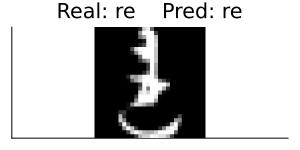

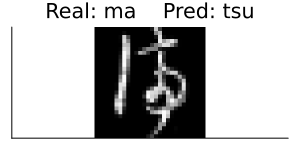

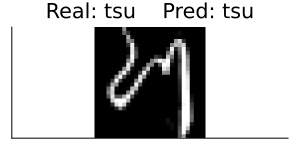

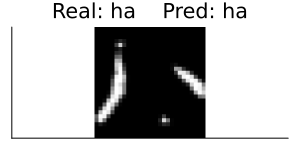

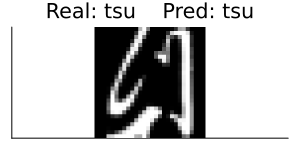

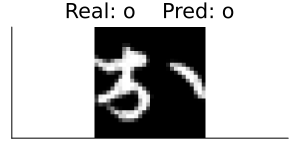

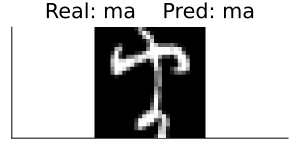

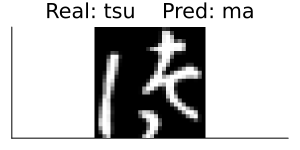

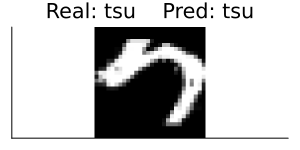

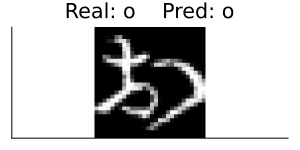

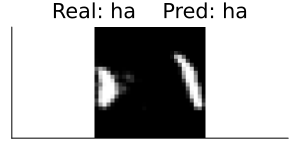

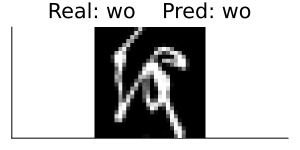

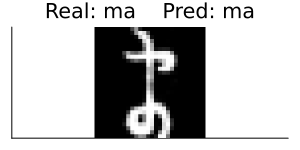

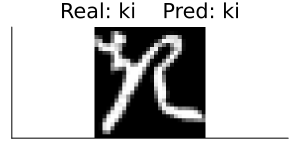

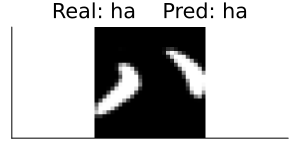

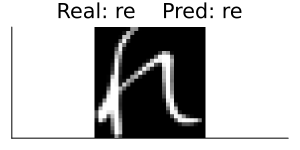

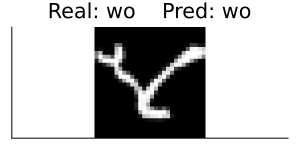

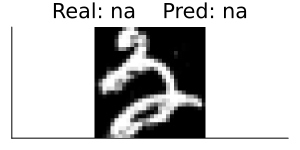

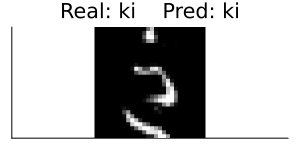

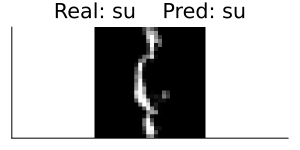

In [251]:
for i in 1:20
    id = rand(1:60000, 1)[1]
    img = train_x[:,:,:,id]
    img_label = [train_y[id]]
    x = Variable(img, name="x")
    y = Variable(img_label, name="y")
    graph = my_cnn(x, y, cnn_params)
    forward!(graph)
    real_label = labels[img_label[1]+1]
    pred = labels[argmax(graph[19].output)]
    display(plot(Gray.(img[:,:,1]), axis=nothing, size=(300,150), title="Real: $real_label    Pred: $pred"))
end

In [241]:
id = rand(1:60000, 1)[1]
img = train_x[:,:,:,id]
img_label = [train_y[id]]
x = Variable(img, name="x")
y = Variable(img_label, name="y")
graph = my_cnn(x, y, cnn_params)
forward!(graph)
println(argmax(graph[19].output), " ", labels[argmax(graph[19].output)], "\n")
graph[19].output

7 ma



10-element Vector{Float64}:
 2.0057083591917837e-5
 0.01987724211461743
 0.04864455213847339
 1.3695398410379242e-5
 0.000217794313915443
 0.0006073701854194173
 0.7163547669594201
 1.5690799162213616e-5
 0.21424631100338043
 2.5200036093797358e-6

7 ma


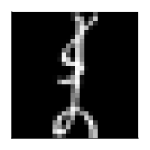

In [242]:
println(img_label[1]+1, " ", labels[img_label[1]+1])

plot(Gray.(img[:,:,1]), axis=nothing, size=(150,150))